In [61]:
import stackstac
import pystac_client
import rioxarray
import xarray as xr
import pyproj
import odc.geo.xr
from pyproj import Proj, transform

import geopandas as gpd

import planetary_computer
from pystac.extensions.eo import EOExtension as eo

import copy

In [48]:
mtwoods = xr.open_zarr(r'F:\MtWoodsRadial\MtWoodsRadial.zarr')

In [49]:
bb = mtwoods.rio.bounds()
centroid = ((bb[0] + bb[2])/2, (bb[1] + bb[3])/2)
centroid

(1001623.0311069412, 1994698.4985454585)

In [53]:
mtwoods.rio.write_crs('EPSG:3107',inplace=True)
mtwoods.rio.crs

CRS.from_epsg(3107)

In [56]:
mtwoods4326 = mtwoods.transpose('band', 'y', 'x').rio.reproject('EPSG:4326')
mtwoods4326.rio.crs

CRS.from_epsg(4326)

In [62]:
x2,y2 = transform(mtwoods.rio.crs,mtwoods4326.rio.crs,centroid[0],centroid[1])
print (x2,y2)


<ipython-input-62-cce8170f1373>:1: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x2,y2 = transform(mtwoods.rio.crs,mtwoods4326.rio.crs,centroid[0],centroid[1])


-32.04791114884368 135.01723502714412


In [4]:
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
#catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
catalog = pystac_client.Client.open(URL)

In [64]:
%%time

time_range = "2000-12-01/2020-12-31"
bbox = list(mtwoods4326.rio.bounds())

search = catalog.search(collections=["aster-l1t"], bbox=bbox, datetime=time_range)
items = search.get_all_items()
len(items)

CPU times: total: 62.5 ms
Wall time: 2.25 s


100

In [18]:
swir_asset = items[0].assets["SWIR"]
available_assets = list(swir_asset.to_dict().keys())
print("properties:", available_assets)

available_bands = [band.name for band in eo.ext(swir_asset).bands]
print("bands:", available_bands)

properties: ['href', 'type', 'title', 'eo:bands', 'proj:bbox', 'proj:shape', 'proj:transform', 'roles']
bands: ['SWIR_Band4', 'SWIR_Band5', 'SWIR_Band6', 'SWIR_Band7', 'SWIR_Band8', 'SWIR_Band9']


In [32]:
stac_new = copy.deepcopy(items)

In [41]:
for index, i in enumerate(items):
     for k in i.assets:
            #print(k)
            if 'VNIR' in k:
                print(k)
                available_bands = [band.name for band in eo.ext(i).bands]
                print("bands:", available_bands)
                for idx, b in enumerate(available_bands):
                    print(eo.ext(i))
                    stac_new[index].assets['B01'] = eo.ext(i).bands[idx]
                

VNIR
bands: ['TIR_Band10', 'TIR_Band11', 'TIR_Band12', 'TIR_Band13', 'TIR_Band14', 'SWIR_Band4', 'SWIR_Band5', 'SWIR_Band6', 'SWIR_Band7', 'SWIR_Band8', 'SWIR_Band9', 'VNIR_Band1', 'VNIR_Band2', 'VNIR_Band3N']
<ItemEOExtension Item id=AST_L1T_00310082005004310_20150511113737>
<ItemEOExtension Item id=AST_L1T_00310082005004310_20150511113737>
<ItemEOExtension Item id=AST_L1T_00310082005004310_20150511113737>
<ItemEOExtension Item id=AST_L1T_00310082005004310_20150511113737>
<ItemEOExtension Item id=AST_L1T_00310082005004310_20150511113737>
<ItemEOExtension Item id=AST_L1T_00310082005004310_20150511113737>
<ItemEOExtension Item id=AST_L1T_00310082005004310_20150511113737>
<ItemEOExtension Item id=AST_L1T_00310082005004310_20150511113737>
<ItemEOExtension Item id=AST_L1T_00310082005004310_20150511113737>
<ItemEOExtension Item id=AST_L1T_00310082005004310_20150511113737>
<ItemEOExtension Item id=AST_L1T_00310082005004310_20150511113737>
<ItemEOExtension Item id=AST_L1T_00310082005004310_20

In [42]:
%time stack_new = stackstac.stack(stac_new)

CPU times: total: 0 ns
Wall time: 28.9 ms


C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pvxarray2\lib\site-packages\stackstac\prepare.py:99: UserWarning: You're filtering for assets that match the mimetype(s) frozenset({'image/x.geotiff', 'image/jp2', 'image/vnd.stac.geotiff', 'image/tiff'}), but since 1 (out of 10) asset(s) have no `type` specified on any item, those will be dropped. Consider passing a list of asset IDs instead to the `assets=` parameter.
Assets with no type: ['B01']
  warnings.warn(


In [43]:
stack_new

,Array,Chunk
Bytes,42.35 GiB,8.00 MiB
Shape,"(18, 3, 9399, 11199)","(1, 1, 1024, 1024)"
Count,6048 Tasks,5940 Chunks
Type,float64,numpy.ndarray


In [6]:
%time stack = stackstac.stack(items)

CPU times: total: 15.6 ms
Wall time: 10.5 ms


In [19]:
stack

,Array,Chunk
Bytes,42.35 GiB,8.00 MiB
Shape,"(18, 3, 9399, 11199)","(1, 1, 1024, 1024)"
Count,6048 Tasks,5940 Chunks
Type,float64,numpy.ndarray


In [66]:
df = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
df.head()

,geometry,created,datetime,platform,proj:epsg,instruments,eo:cloud_cover,view:off_nadir,sat:orbit_state,view:sun_azimuth,view:sun_elevation,aster:processing_number,aster:lower_left_quad_cloud_cover,aster:upper_left_quad_cloud_cover,aster:lower_right_quad_cloud_cover,aster:upper_right_quad_cloud_cover
0,"POLYGON ((128.32954 -32.79049, 129.22919 -32.7...",2015-05-17T13:19:19.572000Z,2006-12-22T01:33:30.997000Z,terra,32652,[aster],32.0,1.004,descending,75.010757,64.115839,55840,12.0,46.0,34.0,37.0
1,"POLYGON ((128.47584 -32.26022, 129.37022 -32.2...",2015-05-17T13:19:37.043000Z,2006-12-22T01:33:22.131000Z,terra,32652,[aster],78.0,1.004,descending,75.895099,64.282439,15282,38.0,100.0,77.0,98.0
2,"POLYGON ((128.62135 -31.72891, 129.51059 -31.7...",2015-05-17T13:19:03.015000Z,2006-12-22T01:33:13.264000Z,terra,32652,[aster],91.0,1.004,descending,76.795178,64.443346,16385,90.0,90.0,94.0,88.0
3,"POLYGON ((128.76519 -31.19819, 129.65036 -31.1...",2015-05-17T13:19:27.406000Z,2006-12-22T01:33:04.400000Z,terra,32652,[aster],51.0,1.004,descending,77.707471,64.790466,16387,57.0,59.0,18.0,72.0
4,"POLYGON ((128.90835 -30.66726, 129.78862 -30.6...",2015-05-17T13:19:28.967000Z,2006-12-22T01:32:55.534000Z,terra,32652,[aster],100.0,1.004,descending,78.638415,64.938629,75196,100.0,100.0,100.0,100.0


In [20]:
rgb = stack.sel(band=["VNIR"])
rgb

C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pvxarray2\lib\site-packages\dask\array\slicing.py:647: RuntimeWarning: overflow encountered in long_scalars
  maxsize = math.ceil(nbytes / (other_numel * itemsize))
C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pvxarray2\lib\site-packages\xarray\core\indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


,Array,Chunk
Bytes,14.12 GiB,8.00 MiB
Shape,"(18, 1, 9399, 11199)","(1, 1, 1024, 1024)"
Count,8028 Tasks,1980 Chunks
Type,float64,numpy.ndarray


In [21]:
x_utm, y_utm = pyproj.Proj(rgb.rio.crs)(centroid[0],centroid[1])
buffer = 10000  # meters

In [22]:
(x_utm,y_utm)

(454916.5785852597, -3510867.7614978305)

In [23]:
aoi = rgb.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
aoi

<xarray.DataArray 'stackstac-99a226332a9f0bbb56162968739b33f9' (time: 18,
                                                                band: 1,
                                                                y: 1334, x: 1333)>
dask.array<getitem, shape=(18, 1, 1334, 1333), dtype=float64, chunksize=(1, 1, 861, 1024), chunktype=numpy.ndarray>
Coordinates: (12/21)
  * time                                (time) datetime64[ns] 2000-12-13T00:5...
    id                                  (time) <U40 'AST_L1T_0031213200000564...
  * band                                (band) <U4 'VNIR'
  * x                                   (x) float64 4.449e+05 ... 4.649e+05
  * y                                   (y) float64 -3.501e+06 ... -3.521e+06
    created                             (time) <U27 '2015-04-13T14:33:02.8360...
    ...                                  ...
    aster:lower_left_quad_cloud_cover   (time) float64 49.0 0.0 ... 59.0 39.0
    aster:upper_left_quad_cloud_cover   (time) float64 91.0 0.0 ... 19.0 46.0
    platform                            <U5 'terra'
    view:off_nadir                      (time) float64 8.557 2.853 ... 5.699
    title                               (band) <U15 'VNIR Swath data'
    epsg                                int32 32654
Attributes:
    spec:           RasterSpec(epsg=32654, bounds=(370883.5334171562, -357796...
    crs:            epsg:32654
    transform:      | 15.00, 0.00, 370883.53|\n| 0.00,-15.00,-3437003.97|\n| ...
    resolution_xy:  (14.997312309630255, 14.996962947033946)

In [28]:
aoi.sel(band='VNIR').plot()

RuntimeError: Assets must have exactly 1 band, but file 'https://astersa.blob.core.windows.net/aster/images/L1T/2000/12/13/AST_L1T_00312132000005640_20150413142758_55358.VNIR.tif' has 3. We can't currently handle multi-band rasters (each band has to be a separate STAC asset), so you'll need to exclude this asset from your analysis.

In [24]:
import dask.diagnostics
with dask.diagnostics.ProgressBar():
    data = aoi.compute()

[#####                                   ] | 12% Completed |  2.1s


RuntimeError: Assets must have exactly 1 band, but file 'https://astersa.blob.core.windows.net/aster/images/L1T/2000/12/13/AST_L1T_00312132000005640_20150413142758_55358.VNIR.tif' has 3. We can't currently handle multi-band rasters (each band has to be a separate STAC asset), so you'll need to exclude this asset from your analysis.

In [44]:
swir_asset.href

'https://astersa.blob.core.windows.net/aster/images/L1T/2005/10/08/AST_L1T_00310082005004310_20150511113737_30756.SWIR.tif'

In [45]:
swir = rioxarray.open_rasterio(swir_asset.href)

In [46]:
swir

<xarray.DataArray (band: 6, y: 2497, x: 2815)>
[42174330 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1 2 3 4 5 6
  * x            (x) float64 4.137e+05 4.138e+05 ... 4.981e+05 4.981e+05
  * y            (y) float64 -3.496e+06 -3.496e+06 ... -3.571e+06 -3.571e+06
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('ImageData4 SWIR_Swath', 'ImageData5 SWIR_Swath', 'ImageD...

Need to construct our own SWIR, VNIR and TIR data

In [44]:
vmin = data.quantile(0.02).values.item()
vmax = data.quantile(0.98).values.item()

In [45]:
vmin
vmax

4328.0

In [61]:
ds = data.to_dataset(dim="band")
ds

<xarray.Dataset>
Dimensions:                       (time: 3, y: 2000, x: 2000, band: 3)
Coordinates: (12/27)
  * time                          (time) datetime64[ns] 2022-06-05T00:45:58 ....
    id                            (time) <U24 'S2B_54HVK_20220605_1_L2A' ... ...
  * x                             (x) float64 4.449e+05 4.449e+05 ... 4.649e+05
  * y                             (y) float64 6.499e+06 6.499e+06 ... 6.479e+06
    sentinel:product_id           (time) <U60 'S2B_MSIL2A_20220605T003709_N04...
    constellation                 <U10 'sentinel-2'
    ...                            ...
    sentinel:latitude_band        <U1 'H'
    title                         (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    common_name                   (band) object 'red' 'green' 'blue'
    center_wavelength             (band) object 0.6645 0.56 0.4966
    full_width_half_max           (band) object 0.038 0.045 0.098
    epsg                          int32 32754
Dimensions without coordinates: band
Data variables:
    B04                           (time, y, x) float64 2.82e+03 ... 1.757e+03
    B03                           (time, y, x) float64 1.376e+03 ... 1.1e+03
    B02                           (time, y, x) float64 724.0 695.0 ... 569.0
Attributes:
    spec:        RasterSpec(epsg=32754, bounds=(399960.0, 6390220.0, 509760.0...
    crs:         epsg:32754
    transform:   | 10.00, 0.00, 399960.00|\n| 0.00,-10.00, 6500020.00|\n| 0.0...
    resolution:  10.0

In [62]:
ds.band

<xarray.DataArray 'band' (band: 3)>
array([0, 1, 2], dtype=int64)
Coordinates: (12/16)
    constellation                 <U10 'sentinel-2'
    view:off_nadir                int32 0
    sentinel:grid_square          <U2 'VK'
    sentinel:processing_baseline  <U5 '04.00'
    sentinel:boa_offset_applied   bool True
    instruments                   <U3 'msi'
    ...                            ...
    sentinel:latitude_band        <U1 'H'
    title                         (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    common_name                   (band) object 'red' 'green' 'blue'
    center_wavelength             (band) object 0.6645 0.56 0.4966
    full_width_half_max           (band) object 0.038 0.045 0.098
    epsg                          int32 32754
Dimensions without coordinates: band

In [63]:
#rgb = name="rgbato").odc.geo.xr.to_rgba(vmin,vmax)

rgb = odc.geo.xr.to_rgba(ds.median(dim="time"), bands=['B04', 'B03', 'B02'],vmin=vmin, vmax=vmax)

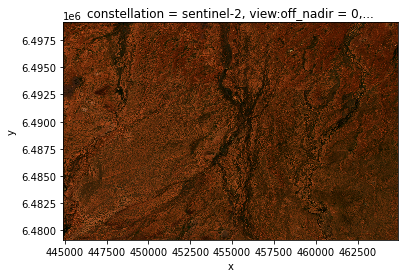

In [65]:
rgb.plot.imshow()

In [69]:
rgb.transpose('band', 'y', 'x').rio.write_crs('EPSG:32754').rio.to_raster(r'F:\Kalkaroo_Sentinel_False_Colour.tif')